In [ ]:
!pip install google-cloud-storage
!pip install pandas

In [1]:
import numpy as np
import pandas as pd

### keep only quality_index_6 >= 0

In [2]:
df_merge_quality = pd.read_csv('US_patent_abstract_50000_2015_with_title_1_5y.csv')
df_merge_quality.shape

(50000, 30)

In [3]:
max(df_merge_quality['quality_index_4'])

0.9568998205930508

In [4]:
min(df_merge_quality['quality_index_4'])

0.0131293670279051

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

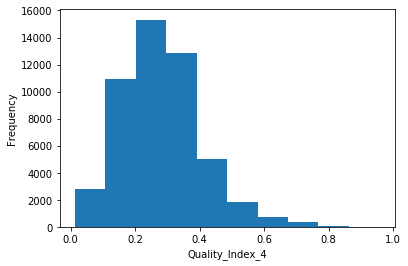

In [6]:
plt.hist(df_merge_quality['quality_index_4'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_4');

In [7]:
df_merge_quality

,Unnamed: 0,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,...,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,text
0,558310,US-8761039-B2,Adaptive generation of channel quality indicat...,20120904,Adaptive generation of channel quality indicat...,What is claimed is: \n \n 1. A user ...,US08761039,410849633,US08761039,2012,...,8,0,0.695102,0.894376,0.666667,2.0,0.376003,0.382909,1,Adaptive generation of channel quality indicat...
1,898437,US-9265347-B2,A mechanism and method for assembling a base t...,20140129,Cam assembly utilizing 2 or more interconnecte...,I claim: \n \n 1. A mechanism for as...,US09265347,421272321,US09265347,2014,...,0,0,NaN,0.816609,0.188235,2.0,0.269591,0.297736,0,Cam assembly utilizing 2 or more interconnecte...
2,1059828,US-9499260-B2,An aircraft landing gear wheel is disclosed. A...,20141014,Aircraft landing gear wheel with integral gear...,We claim: \n \n 1. An aircraft landi...,US09499260,459193604,US09499260,2014,...,3,0,0.586420,0.632653,0.380952,2.0,0.323905,0.331917,1,Aircraft landing gear wheel with integral gear...
3,119949,US-8158424-B2,Previous methods for culturing primate pluripo...,20100405,Primate pluripotent stem cells cultured in med...,1. A method for culturing primate pluripotent ...,US08158424,329269529,US08158424,2010,...,91,0,0.264197,0.612755,0.214286,5.0,0.410151,0.417625,1,Primate pluripotent stem cells cultured in med...
4,488132,US-9106513-B2,Unified Communication and Collaboration (UC&am...,20120323,Unified communication aware networks,What is claimed is: \n \n 1. A metho...,US09106513,410686774,US09106513,2012,...,21,0,0.699325,0.781910,0.090909,3.0,0.296802,0.305626,0,Unified communication aware networks. Unified ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,175577,US-8745608-B2,"A scheduler of a reconfigurable array, a metho...",20100201,"Scheduler of reconfigurable array, method of s...",What is claimed is: \n \n 1. A sched...,US08745608,318230558,US08745608,2010,...,14,0,0.153554,0.879693,0.349206,4.0,0.165703,0.201958,0,"Scheduler of reconfigurable array, method of s..."
49996,828296,US-9102164-B2,A data processing apparatus determines a color...,20130905,"Data processing apparatus, data processing met...",What is claimed is: \n \n 1. An appa...,US09102164,413583822,US09102164,2013,...,2,0,0.513889,0.768935,0.196078,2.0,0.281970,0.310400,0,"Data processing apparatus, data processing met..."
49997,1031377,US-9207365-B2,"According to one embodiment, an imaging lens i...",20140815,Imaging lens and solid state imaging device,What is claimed is: \n \n 1. An imag...,US09207365,438132244,US09207365,2014,...,5,0,0.506651,0.796762,0.129870,1.0,0.336999,0.400449,1,Imaging lens and solid state imaging device. A...
49998,942646,US-9535998-B2,Systems and methods for an information reposit...,20140324,Information repository search system,I claim: \n \n 1. A method comprisin...,US09535998,420403969,US09535998,2014,...,0,0,NaN,0.858850,0.550459,3.0,0.147154,0.200251,0,Information repository search system. Systems ...


### create a model

In [8]:
import pickle as cPickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


In [9]:
MAX_SENT_LENGTH = 30
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [11]:
data_train = df_merge_quality

In [12]:
print(data_train.shape)

(50000, 30)


In [13]:
data_train['quality_rank'].value_counts()

0    29709
1    20291
Name: quality_rank, dtype: int64

In [14]:
29709/50000

0.59418

In [62]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nobu_yamaguchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from nltk import tokenize

claims = []
labels = []
texts = []

for idx in range(data_train.claims_text.shape[0]):

    text = clean_str(str(data_train.iloc[idx]['claims_text']))
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    claims.append(sentences)
    labels.append(data_train.iloc[idx]['quality_rank'])

In [16]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [17]:
data.shape

(50000, 30, 30)

In [18]:
for i, sentences in enumerate(claims):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
            #for word in wordTokens:
                if word in tokenizer.word_index.keys():
                    if (k < MAX_SENT_LENGTH) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1

In [19]:
data[0]

array([[ 226,    7,   81,    7,   12,    2,   63,  621,  760,   22,    1,
         760,   22,   20,   13,  424,   19,  344,  210,  575,   21,    2,
         130,  325,    2,  101,   43, 1234,    2,   31],
       [  28,    1,  760,   22,    3,    8,   12,    6,   36,    3,    1,
         257,   31,    3,  684,    3,   92, 4639,   48,    7,   56,   26,
         442,  175,  367,   88,  367,   94, 2725, 1630],
       [  35,    1,  760,   22,    3,    8,   12,    6,   36,    3,    1,
         257,   31,    3,  684,    3,   92, 4639,   48,   34,   16,   17,
          46, 1069, 2510,   19, 1069, 1657, 2610,    4],
       [  39,    1,  760,   22,    3,    8,   12,    6,   36,    3,    1,
         257,   31,    3,  684,    3,   92, 4639,   48,   34,   15,   23,
          12,    2,    9, 1069,  458,   19, 1069,   42],
       [  44,    2,   24,  435,   25,  210,   63,  621,  760,    1,   24,
          20,  105,    2,  119,   92, 4639,    3,    1,  760,  241,  160,
           3,    1,  760,    6, 

In [20]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 102990 unique tokens.


In [21]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (50000, 30, 30)
Shape of label tensor: (50000, 2)


In [22]:
data[0]

array([[ 226,    7,   81,    7,   12,    2,   63,  621,  760,   22,    1,
         760,   22,   20,   13,  424,   19,  344,  210,  575,   21,    2,
         130,  325,    2,  101,   43, 1234,    2,   31],
       [  28,    1,  760,   22,    3,    8,   12,    6,   36,    3,    1,
         257,   31,    3,  684,    3,   92, 4639,   48,    7,   56,   26,
         442,  175,  367,   88,  367,   94, 2725, 1630],
       [  35,    1,  760,   22,    3,    8,   12,    6,   36,    3,    1,
         257,   31,    3,  684,    3,   92, 4639,   48,   34,   16,   17,
          46, 1069, 2510,   19, 1069, 1657, 2610,    4],
       [  39,    1,  760,   22,    3,    8,   12,    6,   36,    3,    1,
         257,   31,    3,  684,    3,   92, 4639,   48,   34,   15,   23,
          12,    2,    9, 1069,  458,   19, 1069,   42],
       [  44,    2,   24,  435,   25,  210,   63,  621,  760,    1,   24,
          20,  105,    2,  119,   92, 4639,    3,    1,  760,  241,  160,
           3,    1,  760,    6, 

In [58]:
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)

In [23]:
#data = data[indices]
#labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
nb_test_samples = int(TEST_SPLIT * data.shape[0])

In [24]:
x_train = data[:-(nb_validation_samples+nb_test_samples)]
y_train = labels[:-(nb_validation_samples+nb_test_samples)]
x_val = data[-(nb_validation_samples+nb_test_samples):-nb_test_samples]
y_val = labels[-(nb_validation_samples+nb_test_samples):-nb_test_samples]
x_test = data[-nb_test_samples:]
y_test = labels[-nb_test_samples:]

In [25]:
print('Number of positive and negative reviews in traing, validation, and test set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Number of positive and negative reviews in traing, validation, and test set
[20815. 14185.]
[5898. 4102.]
[2996. 2004.]


In [26]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops

import scipy.sparse


# Helper libraries
#from w266_common import utils, vocabulary, tf_embed_viz
#import glove_helper; reload(glove_helper)

#hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

import zipfile
with zipfile.ZipFile("data/glove/glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall("data/glove")

In [27]:
GLOVE_DIR = "data/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [28]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [82]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

In [83]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
 
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) #

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)


        #if mask is not None:
        #    # Cast the mask to floatX to avoid float64 upcasting in theano
        #    print('mask')
        #    ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        ait = K.expand_dims(ait)
 
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [84]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

tracking <tf.Variable 'att_layer_11/W:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_11/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_11/u:0' shape=(100, 1) dtype=float32> u


In [85]:
claims_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
claims_encoder = TimeDistributed(sentEncoder)(claims_input)
l_lstm_sent = Bidirectional(GRU(30, return_sequences=True))(claims_encoder)

In [86]:
l_lstm_sent.shape

TensorShape([None, 30, 60])

In [87]:
#l_att_sent = AttLayer(100)(l_lstm_sent)
l_att_sent = AttLayer(100)(l_lstm_sent)

tracking <tf.Variable 'att_layer_12/W:0' shape=(60, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_12/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_12/u:0' shape=(100, 1) dtype=float32> u


In [88]:
l_att_dense = Dense(100, activation='relu')(l_att_sent)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_sent_drop = Dropout(rate=0.1)(l_att_dense)
preds = Dense(2, activation='sigmoid')(l_att_sent_drop)
model = Model(claims_input, preds)

In [89]:
preds.shape

TensorShape([None, 2])

In [90]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [91]:
print("model fitting - Hierachical attention network 0.1")
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=50)

model fitting - Hierachical attention network 0.1
Train on 35000 samples, validate on 10000 samples
Epoch 1/10
35000/35000 [==============================] - 445s 13ms/step - loss: 0.6083 - acc: 0.6717 - val_loss: 0.5936 - val_acc: 0.6751
Epoch 2/10
35000/35000 [==============================] - 441s 13ms/step - loss: 0.5921 - acc: 0.6880 - val_loss: 0.5856 - val_acc: 0.6907
Epoch 3/10
35000/35000 [==============================] - 441s 13ms/step - loss: 0.5845 - acc: 0.6932 - val_loss: 0.5870 - val_acc: 0.6884
Epoch 4/10
35000/35000 [==============================] - 441s 13ms/step - loss: 0.5751 - acc: 0.6997 - val_loss: 0.5801 - val_acc: 0.6895
Epoch 5/10
35000/35000 [==============================] - 442s 13ms/step - loss: 0.5647 - acc: 0.7052 - val_loss: 0.5878 - val_acc: 0.6930
Epoch 6/10
35000/35000 [==============================] - 442s 13ms/step - loss: 0.5543 - acc: 0.7137 - val_loss: 0.5878 - val_acc: 0.6927
Epoch 7/10
35000/35000 [==============================] - 441s 13m

In [48]:
pred_test = model.predict(x_val)
np.savetxt('HATT_50k_5y.csv', pred_test)

In [49]:
model.save("model/HATT_50k_5y")

In [71]:
test_result = model.evaluate(x_test, y_test)
print("test loss, test acc:", test_result)

5000/5000 [==============================] - 17s 3ms/step
test loss, test acc: [0.5840323395729065, 0.6898999810218811]


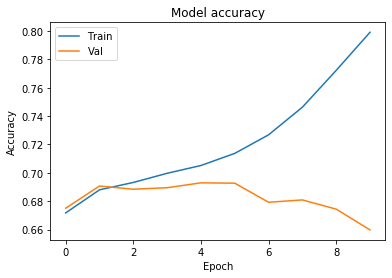

In [92]:
# Plot training & validation accuracy values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()